# The PyOPIA Particle STATS

How to create STATS, how is it structured, and how to plot a volume distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import pyopia.classify
import pyopia.process
import pyopia.statistics
import pyopia.pipeline
import pyopia.instrument.silcam
import pyopia.io
import pyopia.tests.testdata

## Process an example image

First, we can setup and example pre-trained CNN, available from the {mod}`pyopia.tests` module.

In [2]:
model_path = pyopia.tests.testdata.get_example_model(os.getcwd())

Now we can use a config file to define a set of processing steps for a SilCam image ({mod}`pyopia.instrument.silcam`). You can generate this config file using `pyopia generate-config` (see the 'Command line tools' page for more info), or you could have a look at some of the example config files in the [notebooks](https://github.com/SINTEF/pyopia/tree/main/notebooks) folder

In [3]:
toml_settings = pyopia.io.load_toml('config.toml')

And run the {class}`pyopia.pipeline.Pipeline` class

In [4]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(toml_settings)

# Load an image (from the test suite)
filename = pyopia.tests.testdata.get_example_silc_image(os.getcwd())

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
raw_files: raw_data/*.silc
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['settings', 'raw_files'])
Pipeline ready with these data:  ['settings', 'raw_files', 'cl']
SilCamLoad  ready with: {}  and data dict_keys(['settings', 'raw_files', 'cl', 'filename'])
ImagePrep  ready with: {'image_level': 'imraw'}  and data dict_keys(['settings', 'raw_files', 'cl', 'filename', 'timestamp', 'imraw'])
Segment  ready with: {'threshold': 0.85}  and data dict_keys(['settings', 'raw_files', 'cl', 'filename', 'timestamp', 'imraw', 'imref', 'imc'])
segment
clean
CalculateStats  ready with: {}  and data dict_keys(['settings', 'raw_files', 'cl', 'filename', 'timestamp', 'imraw', 'imref', 'imc', 'imbw'])
statextract
21.7% saturation
measure
  870 particles found
WARNING. exportparticles temporarily modified for 2-d images without color!
EXTRACTING 870 IMAGES from 870
StatsH5  ready with: {'output_datafile': './test'}  and data dict_keys(['settings', 'raw_fi

Note: the returned stats from `stats = processing_pipeline.run(filename)` are single-image only and not appended if you loop through several filenames! It is recommended to use this step as part of pipeline that uses {class}`pyopia.io.StatsToDisc` for properly appending data into NetCDF format when processing several files.

## The STATS DataFrame

This is the main [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas-dataframe) containing the processed information about every particle measured.

This does not contain any calibrated values, so dimentions (e.g. equivalent_diameter etc.) and positions of ROI bounding boxes (e.g. minr etc.) are all in pixels (not microns). This allows for altering pixels size without having to re-process if a post-calibration is performed on the data, for example.

The position of each particle within the original raw image are given by the bounding box at location (minr, minc, maxr, maxc) - with r and c being rows and columns, respectively.

Classification probabilities are given by columns with 'probability_*'. Note: If `[steps.classifier]`is not defined in the config, the classification will be skipped and no probabilities reported. To use PyOPIA's Classification module requires the extra dependencies (pip install pyopia[classification] or pip install pyopia[classification-arm64])

In [5]:
# print the stats DataFrame
stats.head()

,major_axis_length,minor_axis_length,equivalent_diameter,minr,minc,maxr,maxc,probability_oil,probability_other,probability_bubble,probability_faecal_pellets,probability_copepod,probability_diatom_chain,probability_oily_gas,export name,timestamp,saturation
0,6.175643,2.743739,3.908820,3.0,77.0,8.0,81.0,0.325525,0.071786,0.483174,0.00343,0.002331,0.005164,0.10859,D20181101T142731.838206-PN0,2018-11-01 14:27:31.838206,21.666268
1,15.518777,13.091788,14.138550,3.0,1896.0,18.0,1912.0,0.325525,0.071786,0.483174,0.00343,0.002331,0.005164,0.10859,D20181101T142731.838206-PN1,2018-11-01 14:27:31.838206,21.666268
2,21.233102,18.983567,20.026744,4.0,181.0,26.0,202.0,0.325525,0.071786,0.483174,0.00343,0.002331,0.005164,0.10859,D20181101T142731.838206-PN2,2018-11-01 14:27:31.838206,21.666268
3,37.163209,34.977428,36.019871,4.0,282.0,41.0,318.0,0.325525,0.071786,0.483174,0.00343,0.002331,0.005164,0.10859,D20181101T142731.838206-PN3,2018-11-01 14:27:31.838206,21.666268
4,7.765540,7.365920,7.225152,4.0,1444.0,12.0,1452.0,0.325525,0.071786,0.483174,0.00343,0.002331,0.005164,0.10859,D20181101T142731.838206-PN4,2018-11-01 14:27:31.838206,21.666268


## Analysis, statistics and plotting

There are lots of functions in {mod}`pyopia.statistics`. Here is just an example using {func}`pyopia.statistics.vd_from_stats`

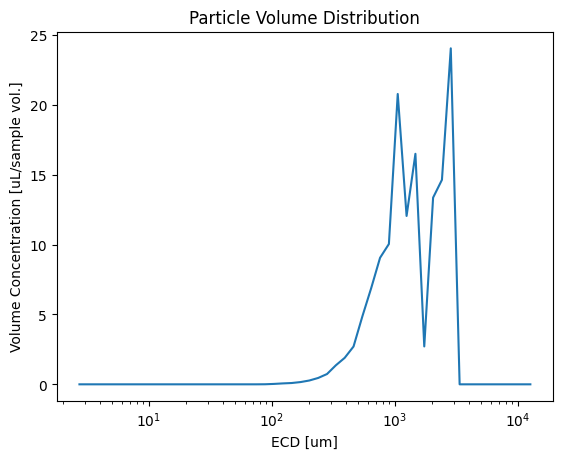

In [6]:
# Calculate the volume distribution from the stats DataFrame.
# (Usually several images would be needed for statistics to converge.
# This can be done by appending new image stats to the DataFrame)
dias, vd = pyopia.statistics.vd_from_stats(stats, 24)

# plot the volume distribution
plt.plot(dias, vd)
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Concentration [uL/sample vol.]')
plt.title('Particle Volume Distribution')
plt.show()